In [45]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import os
import cv2

def convert_coordinates(df):
    x_min, y_min = df['x'].min(), df['y'].min()
    interval_length_x = df['x'].drop_duplicates().sort_values().diff().value_counts().idxmax()
    interval_length_y = df['y'].drop_duplicates().sort_values().diff().value_counts().idxmax()

    df_converted = df.copy()
    df_converted['x'] = ((df_converted['x'] - x_min) / interval_length_x).round().astype(int)
    df_converted['y'] = ((df_converted['y'] - y_min) / interval_length_y).round().astype(int)
    return df_converted

def create_intensity_image(df_intensity, df_coordinates, mz_value, scale_factor=0.1,
                          norm=True,denoise=False, smooth=False, smooth_method='gaussian', kernel_size=5):
    
    # Extracting intensity values for the specified m/z
    intensities = df_intensity[df_intensity['m/z'] == mz_value].iloc[0, 1:]

    # Scaling down the coordinates
    df_coordinates_scaled = df_coordinates.copy()
    df_coordinates_scaled['x'] = (df_coordinates_scaled['x'] * scale_factor).astype(int)
    df_coordinates_scaled['y'] = (df_coordinates_scaled['y'] * scale_factor).astype(int)

    # Creating a blank image with dimensions based on the max coordinates
    max_x, max_y = df_coordinates_scaled['x'].max(), df_coordinates_scaled['y'].max()
    image = np.zeros((max_y + 1, max_x + 1))

    # Mapping each spot's intensity to its coordinates in the image
    for spot, intensity in intensities.items():
        spot_number = int(spot.split(' ')[1])
        x, y = df_coordinates_scaled[df_coordinates_scaled['Spot'] == spot_number][['x', 'y']].iloc[0]
        image[y, x] = intensity
    # Normalizing the image for better visualization
    if norm:
        image = (image - np.min(image)) / (np.max(image) - np.min(image))
    if image.dtype != np.uint8:
        image = (255 * image).astype(np.uint8)
    if denoise:
        image = cv2.fastNlMeansDenoising(image, None)

    # Smooth the image
    if smooth:
        if smooth_method == 'gaussian':
            image = cv2.GaussianBlur(image, (kernel_size, kernel_size), 0)
        elif smooth_method == 'median':
            image = cv2.medianBlur(image, kernel_size)

    return image

def find_closest_mz_name(mz_value, df_feature_list):
    # Find the closest m/z value
    closest_match = df_feature_list.iloc[(df_feature_list['m/z'] - mz_value).abs().argsort()[:1]]
    return closest_match['Name'].values[0]
# def getIntContour(image,thres):
    
#     image_values = np.array(image[image!=0])#background is 0(including the non-background but intensity is 0)
    
#     if len(image_values) == 0: return image,image,image
    
#     t1,t2,t3 = thres
    
#     # Calculate the percentiles for the non-transparent (alpha != 0) part of the image
#     p1 = np.percentile(image_values, t1)
#     p2 = np.percentile(image_values, t2)
#     p3 = np.percentile(image_values, t3)

#     # Create masks based on the calculated percentiles only for non-transparent pixels
#     type1_mask = (image >= p1) & (image != 0)
#     type2_mask = (image >= p2) & (image != 0)
#     type3_mask = (image >= p3) & (image != 0)

#     # Convert masks to binary images
#     type1 = np.zeros_like(image, dtype=np.uint8)
#     type2 = np.zeros_like(image, dtype=np.uint8)
#     type3 = np.zeros_like(image, dtype=np.uint8)

#     type1[type1_mask] = 1
#     type2[type2_mask] = 1
#     type3[type3_mask] = 1

#     # Find contours for each type using cv2.RETR_LIST
#     contours1_list, _ = cv2.findContours(type1, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
#     contours2_list, _ = cv2.findContours(type2, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
#     contours3_list, _ = cv2.findContours(type3, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

    
#     image_rgb = cv2.cvtColor((image * 255).astype(np.uint8), cv2.COLOR_GRAY2RGB)

#     # Create a copy of the image with contours drawn
#     overlaid_image1 = image_rgb.copy()
#     overlaid_image2 = image_rgb.copy()
#     overlaid_image3 = image_rgb.copy()

#     # Draw contours for each set on the overlaid image
#     for contours1 in contours1_list:
#         cv2.drawContours(overlaid_image1, contours1, -1, (0, 0, 255), thickness=2)  # Red color for contours
#     for contours2 in contours2_list:
#         cv2.drawContours(overlaid_image2, contours2, -1, (0, 255, 0), thickness=2)  # Green color for contours
#     for contours3 in contours3_list:
#         cv2.drawContours(overlaid_image3, contours3, -1, (255, 0, 0), thickness=2)  # Blue color for contours
    

#     return overlaid_image1,overlaid_image2,overlaid_image3


In [38]:
image.dtype

dtype('float64')

In [4]:
import pandas as pd
import matplotlib.image as mpimg
import os
import matplotlib.lines as mlines
def main(parent_dir,file_intensity,file_coordinates,feature_list_path,skip_rows_intensity,skip_rows_coordinates):
    
    # File paths
    
    out_dir = os.path.join(parent_dir,'constructedImages')
    os.makedirs(out_dir, exist_ok=True)

    scale_bar_micrometers = 100
    scale_bar_pixels = scale_bar_micrometers / 20  # Convert to pixels (each pixel is 20 micrometers)


    df_feature_list = pd.read_csv(feature_list_path, delimiter=';', skiprows=8)
    #image_software_dir = '/mnt/data10/shared/yujie/raffat_data/MCF7/Spheroid6_A2_B2_Laser70_Metabolites_rawDATA/scilab_fig'

    df_intensity = pd.read_csv(file_intensity, skiprows=skip_rows_intensity, header=0, delimiter=';')


    df_coordinates = pd.read_csv(file_coordinates, skiprows=skip_rows_coordinates, delimiter=';')

    # Renaming columns in df_coordinates for clarity
    df_coordinates.columns = ['Spot', 'x', 'y']
    #!!!!!mismatch between the 2 df(regions start from spot 0, intensities start from spot 1)
    df_coordinates['Spot'] = df_coordinates['Spot']+1

    #select only the spots used in df_intensities
    spot_numbers = [int(col.split(' ')[1]) for col in df_intensity.columns if 'Spot' in col]
    selected_coordinates = df_coordinates[df_coordinates['Spot'].isin(spot_numbers)]
    #print(selected_coordinates.head(5))

    #convert from micro to pixel
    df_converted_coordinates = convert_coordinates(selected_coordinates)
    # Directory for saving images
    #output_dir = '/path/to/output/directory'
    #os.makedirs(output_dir, exist_ok=True)

    num_mz_values = len(df_intensity['m/z'])
    print(f'parent dir {parent_dir} \n feature list {feature_list_path} \n total number of m/z values: {num_mz_values}')



    for idx, mz_value in enumerate(df_intensity['m/z']):
    #     fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(36, 36))
    #     ax1 = axes[idx,0]
        fig, ax1 = plt.subplots(figsize=(10, 10))
        # Generate the image
        mz_name = find_closest_mz_name(mz_value, df_feature_list)
        mz_name = mz_name.replace(":","-")
        image = create_intensity_image(df_intensity, df_converted_coordinates, mz_value, 1)


        cax = ax1.imshow(np.flipud(image), cmap='jet')#flip upside down
        #ax1.set_title(f'{mz_value} -{mz_name}- reconstructed')
        ax1.axis('off')  # Turn off axis
        fig.colorbar(cax, ax=ax1, orientation='vertical',shrink=.78,aspect=20)

    #     thres = (80,90,95)
    #     overlaid_image_list= getIntContour(image,thres)
    #     for j in range(1,4):
    #         ax = axes[idx,j]
    #         cax = ax.imshow(np.flipud(overlaid_image_list[j]))#flip upside down
    #         ax.set_title(f'{thres[j]}- percentile contour')
    #         ax.axis('off') 
        bar_x_position = 3
        bar_y_position = image.shape[0] - 4
        line = mlines.Line2D([bar_x_position, bar_x_position + scale_bar_pixels], 
                             [bar_y_position, bar_y_position], 
                             color='white', linewidth=2)
        ax1.add_line(line)

        # Add text label for the scale bar below the line
        ax1.text(bar_x_position, bar_y_position + 2, f'{scale_bar_micrometers} μm', 
                color='white', fontsize=10, verticalalignment='bottom')


        #plt.tight_layout()
        out_file_path = os.path.join(out_dir,f'{mz_value}_{mz_name}_reconstructed.png')
        fig.savefig(out_file_path)
        plt.show()
        plt.close(fig)
        print(f'{mz_value}-{mz_name} done')





    #main()

parent dir /mnt/data10/shared/yujie/raffat_data/Raw Data/NA/A3/Met/230703Spheroids-6-A3-Laser60_left_NA_rawDATA_outer 
 feature list /mnt/data10/shared/yujie/raffat_data/Raw Data/NA/A3/Met/230703Spheroids-6-A3-Laser60_left_NA_rawDATA_outer/K17Metabolites-Raafat-FeatureList.csv 
 total number of m/z values: 64


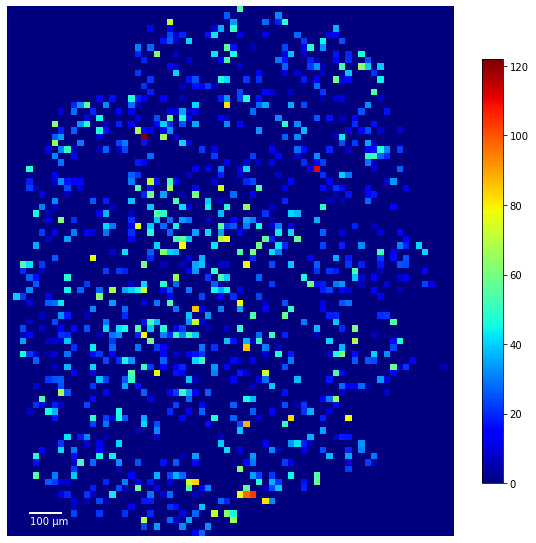

87.054824-pyruvate done


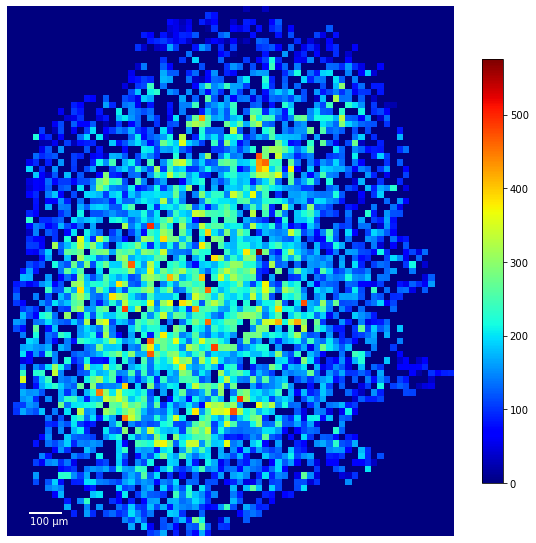

89.02441806-lactate done


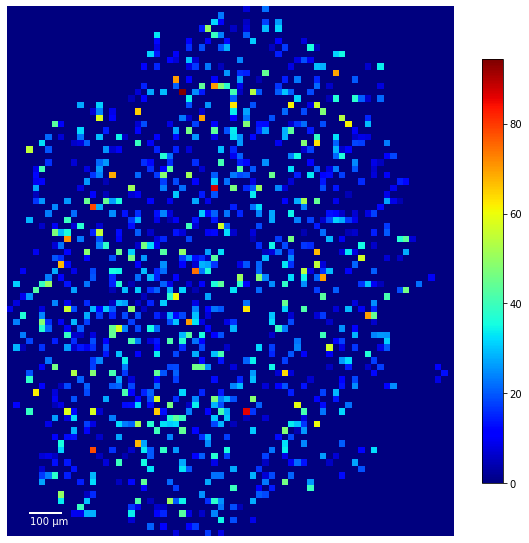

104.0353171-Serine done


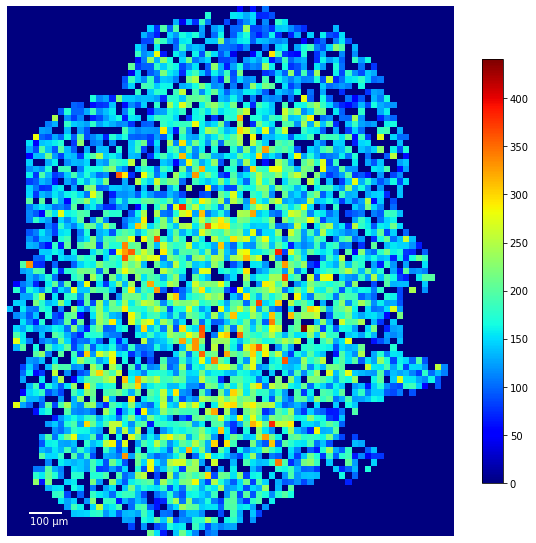

115.00368259999999-Fumarate done


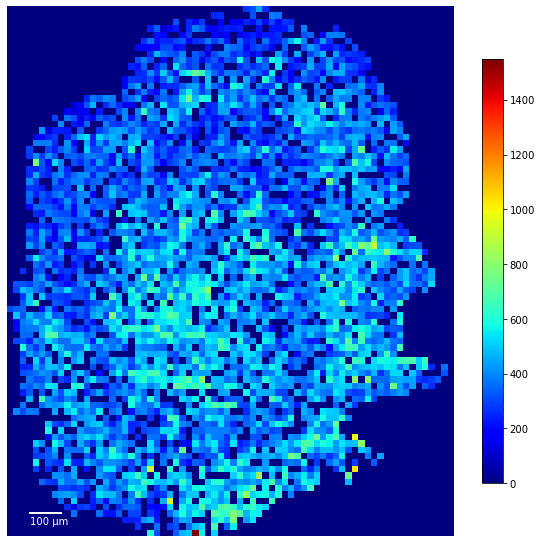

117.0193327-succinate done


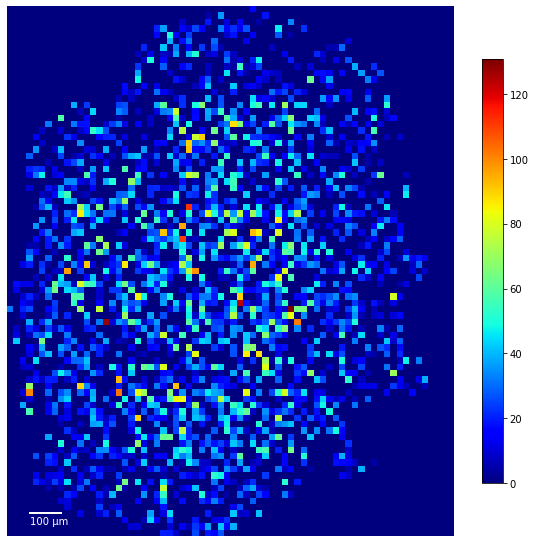

130.9985972-oxaloacetate done


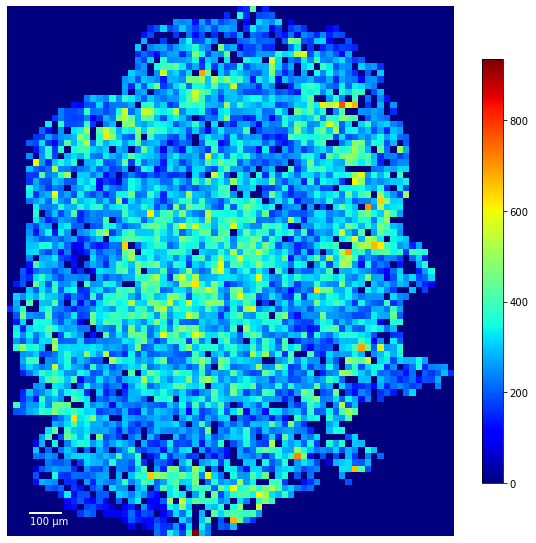

132.0302317-aspartate done


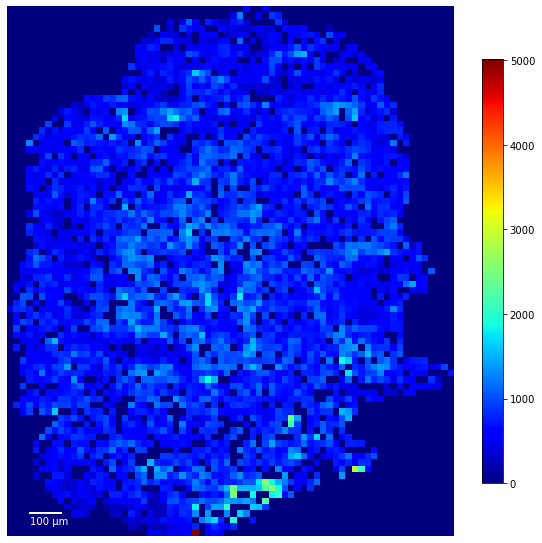

133.0142473-Malate done


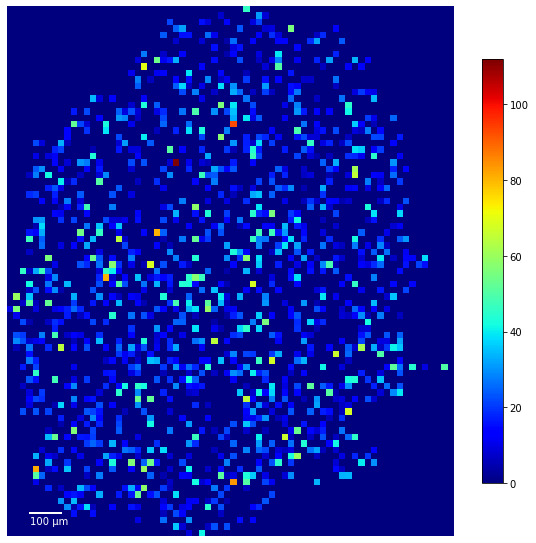

145.01424730000002-2-Ketoglutarate done


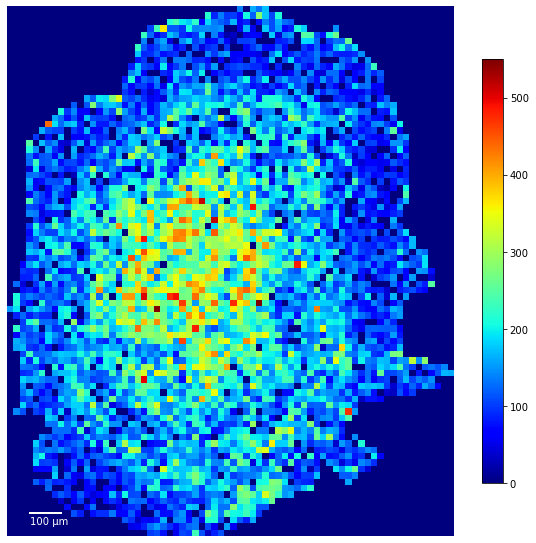

145.06186619999997-Glutamine  done


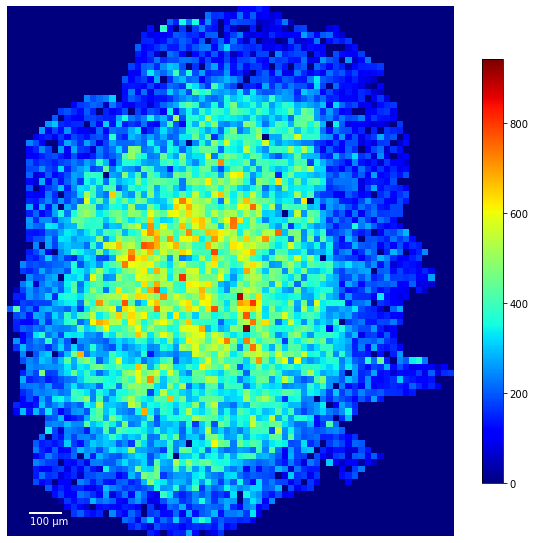

146.04588180000002-glutamate done


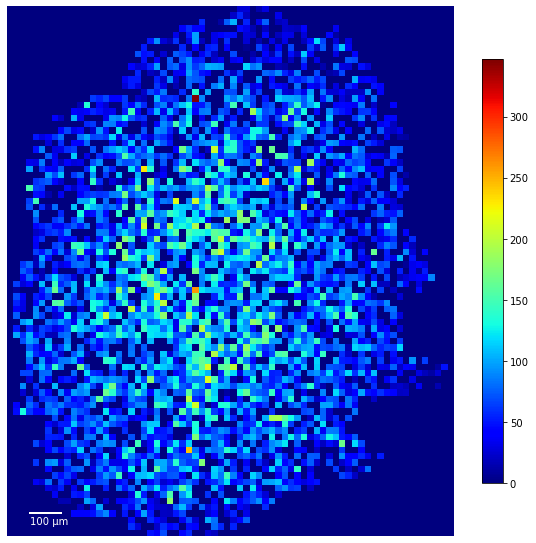

147.0298974-2-Hydroxyglutarate done


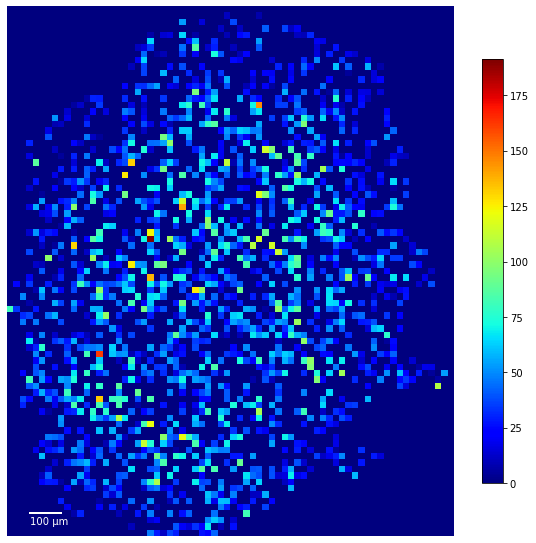

155.0098306-Orotic acid done


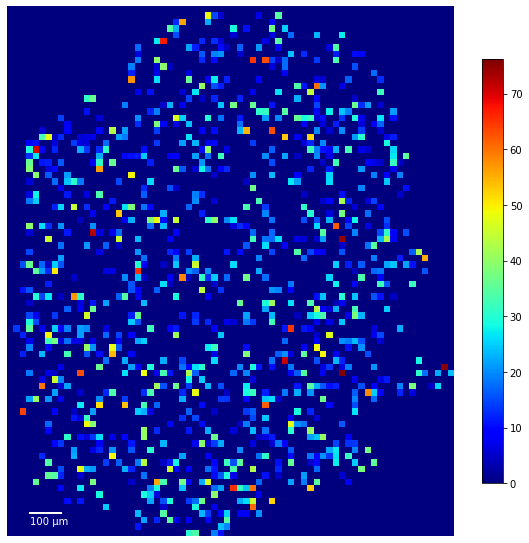

157.02548069999997-dihydroorotate  done


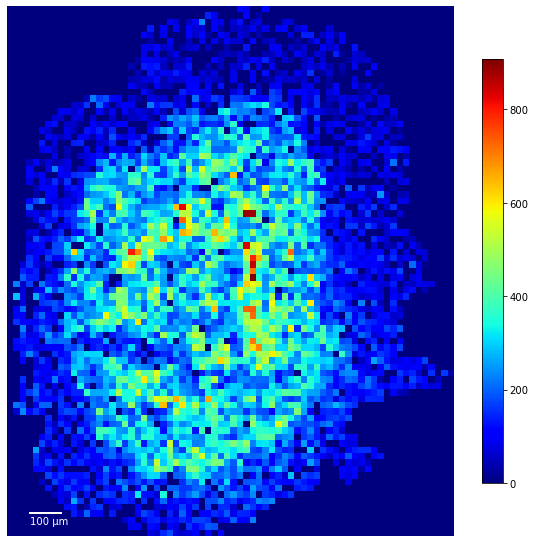

166.9750984-Phosphoenolpyruvate  done


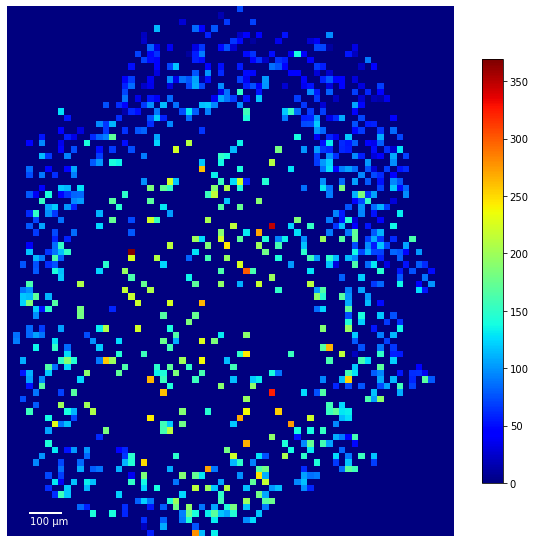

168.99074850000002-Glyceraldehyde 3-p done


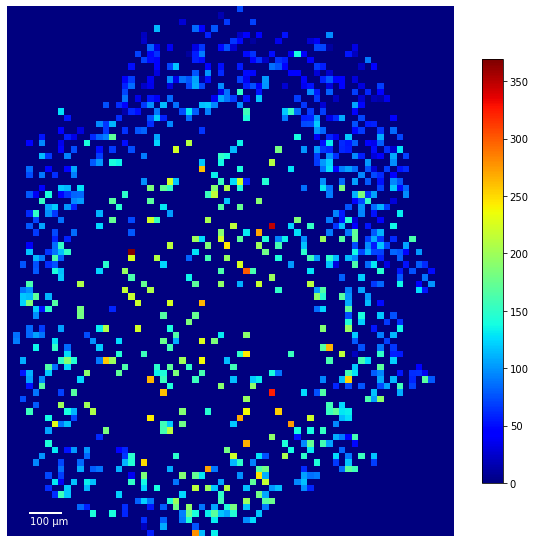

168.99074850000002-Glyceraldehyde 3-p done


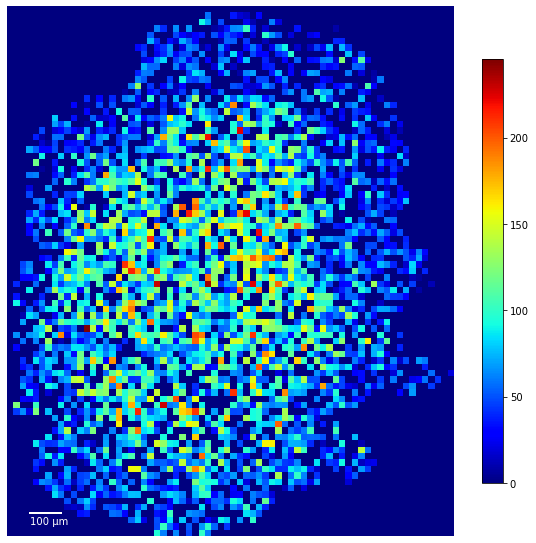

173.00916189999998-Aconitate done


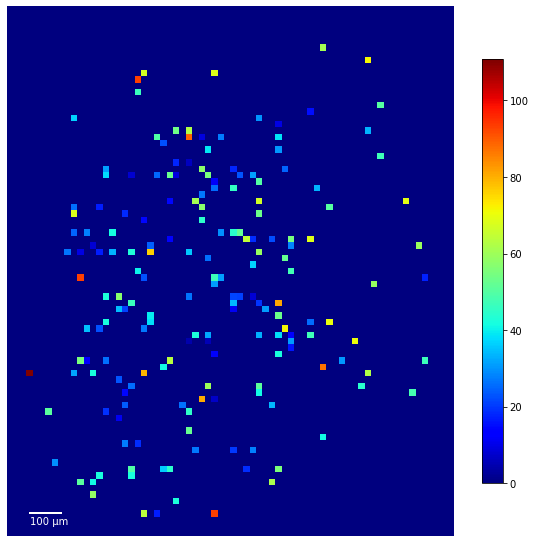

175.0360454-Carbamoyl Asp. done


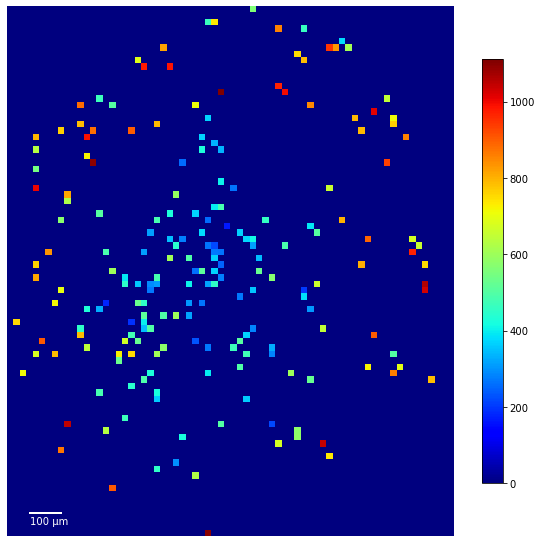

179.0561121-Glucose done


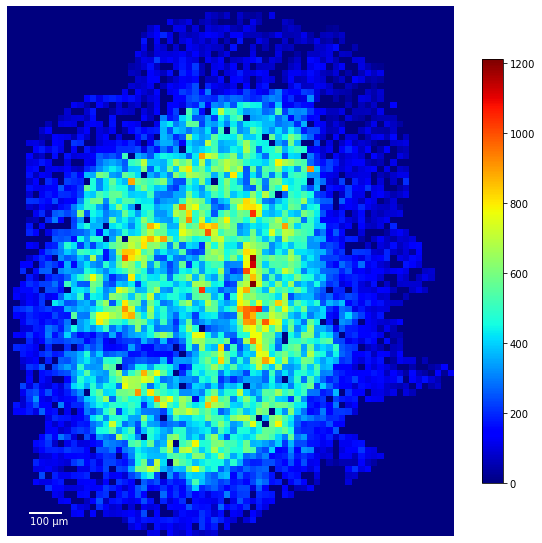

184.9856631-phosphoglycerate done


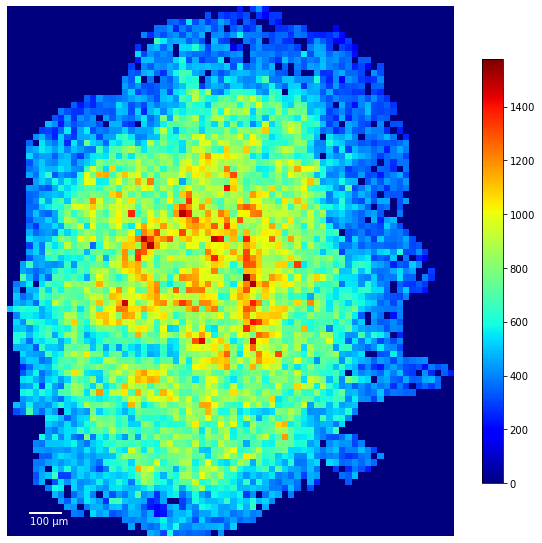

191.01972659999998-citrate done


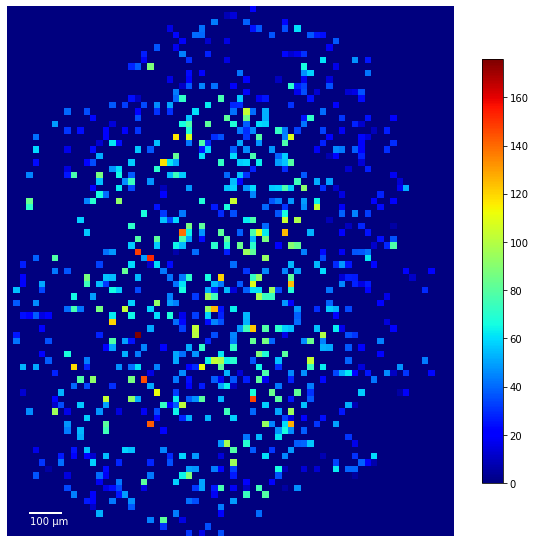

199.0013132-Erythrose 4-p done


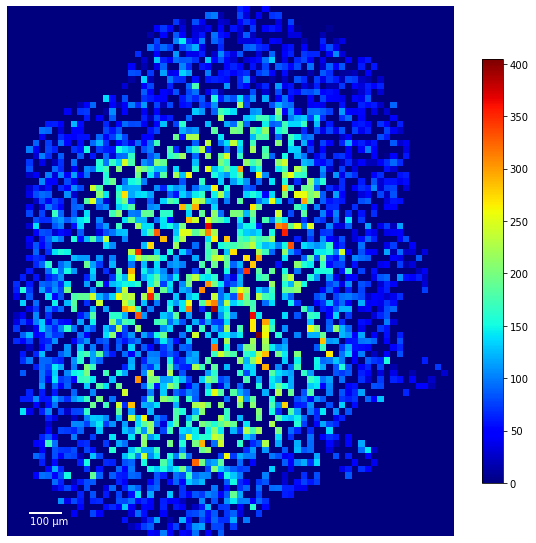

229.01187779999998-Ribulose 5-p done


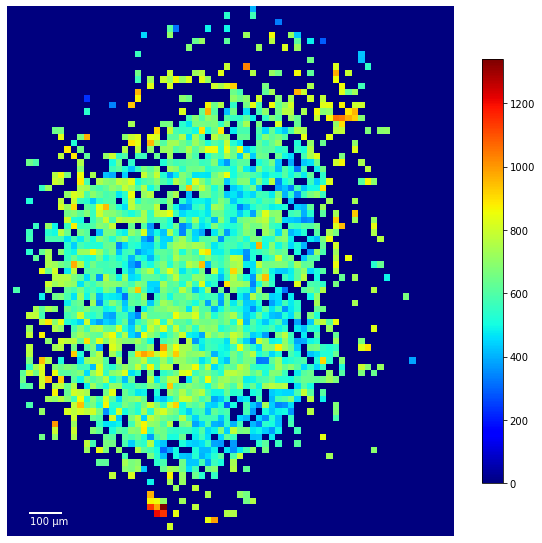

242.07824399999998-Cytidine done


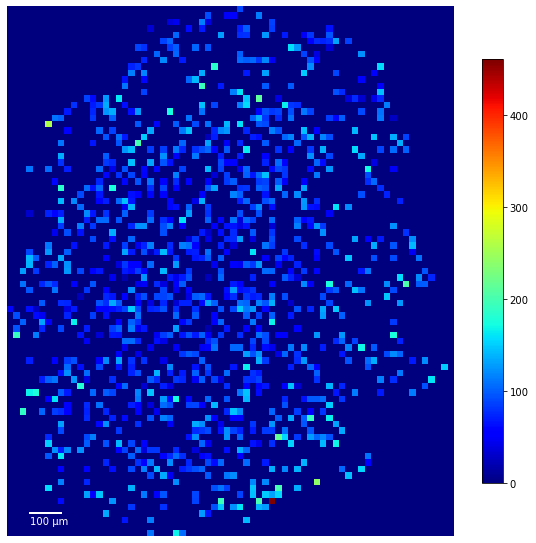

243.062264-Uridine done


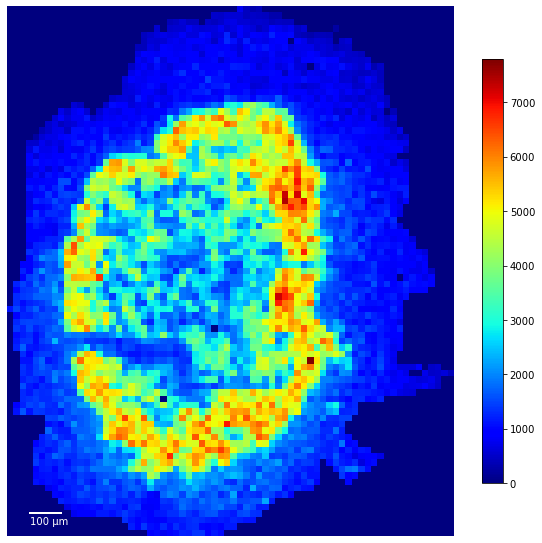

259.02244249999995-Glucose 6-p done


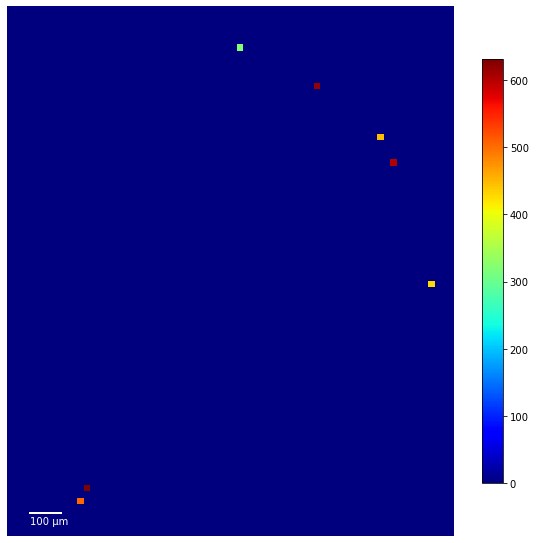

267.073494-Inosine done


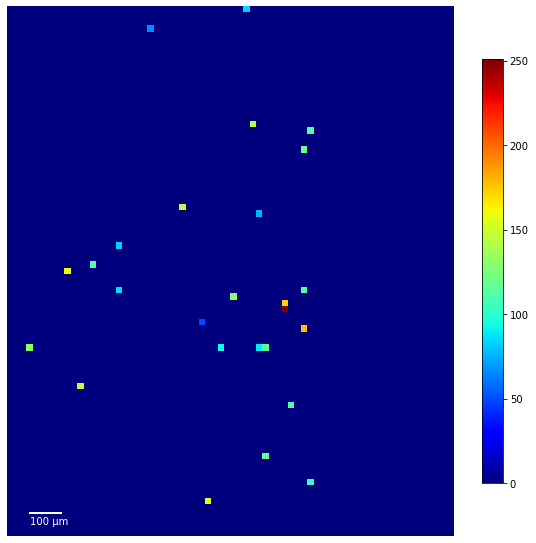

275.0173571-6-Phosphogluconate done


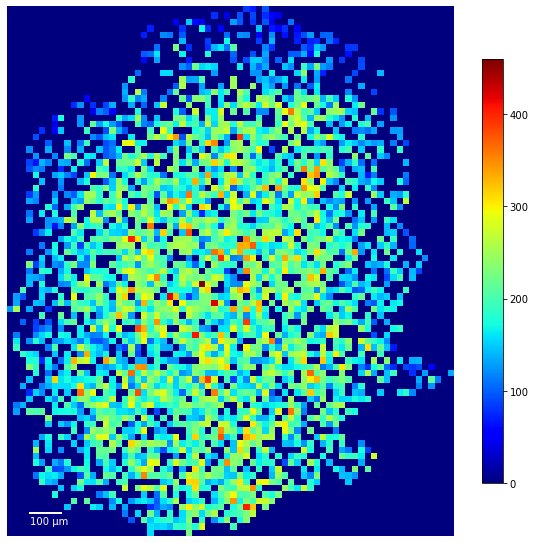

282.084394-Guanosine done


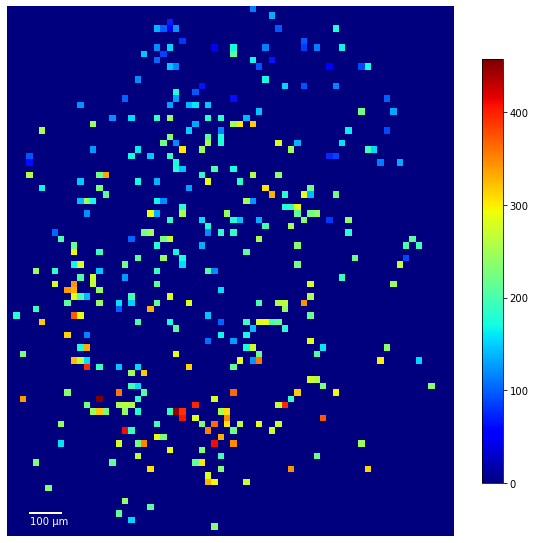

289.0330072-Sedoheptulose 7-p done


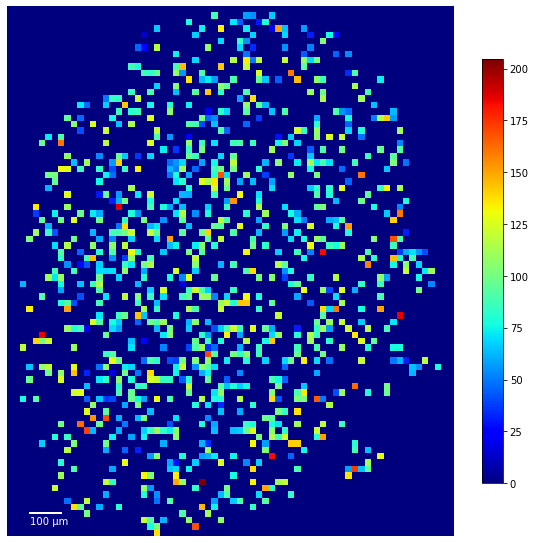

306.0496603-dCMP done


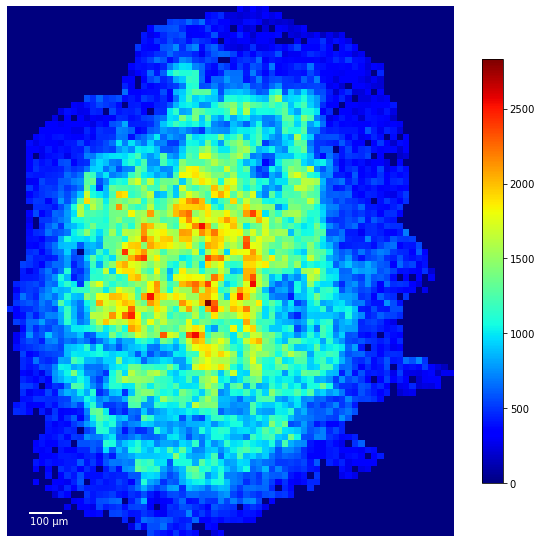

306.07653-Glutathione done


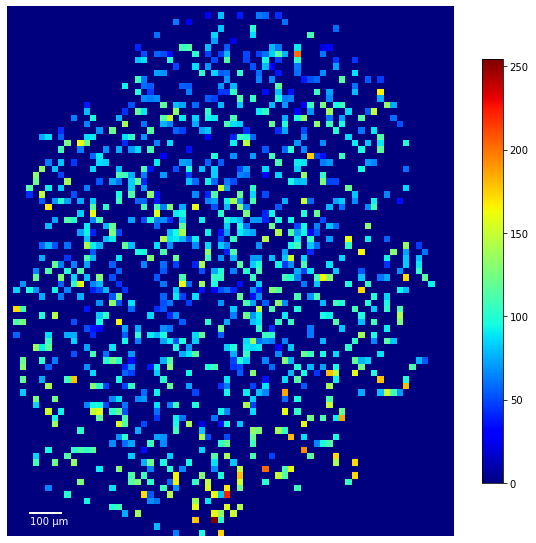

307.03367589999993-dUMP done


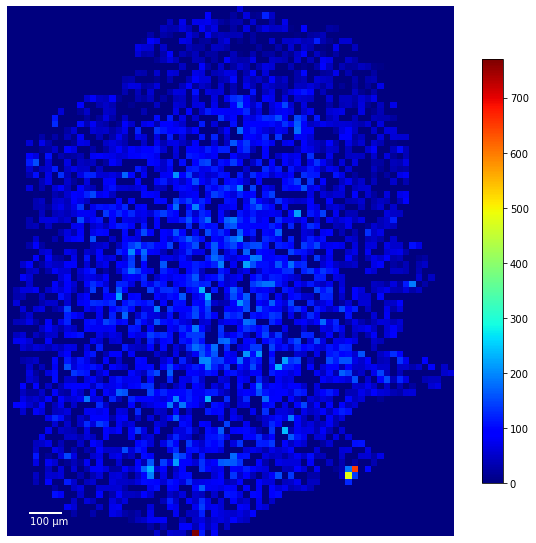

321.04932599999995-dTMP done


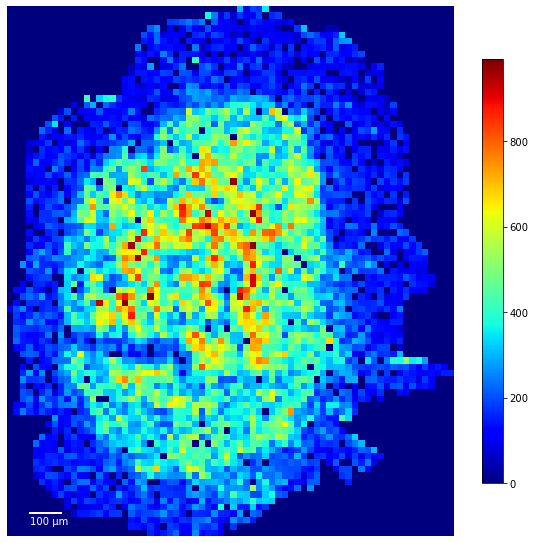

322.044575-CMP done


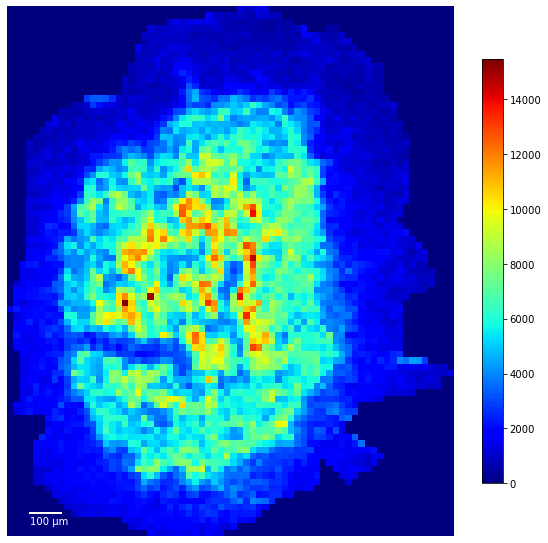

323.0285905-UMP done


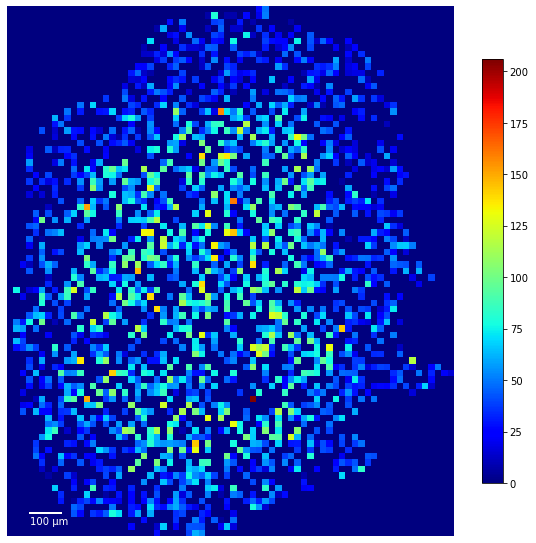

337.055424-AICAR done


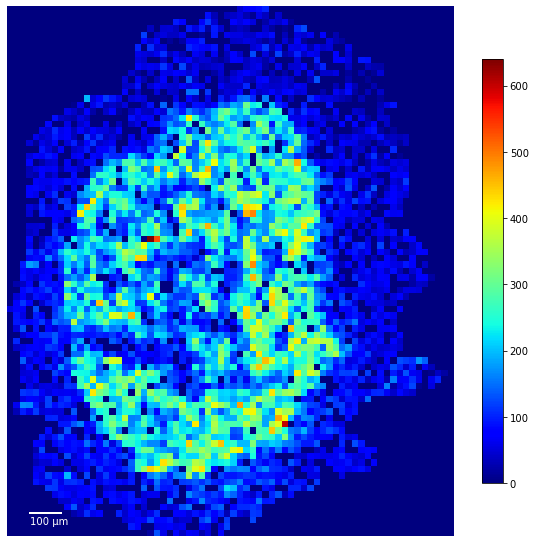

338.98877289999996-Fructose 1,6 phosphate done


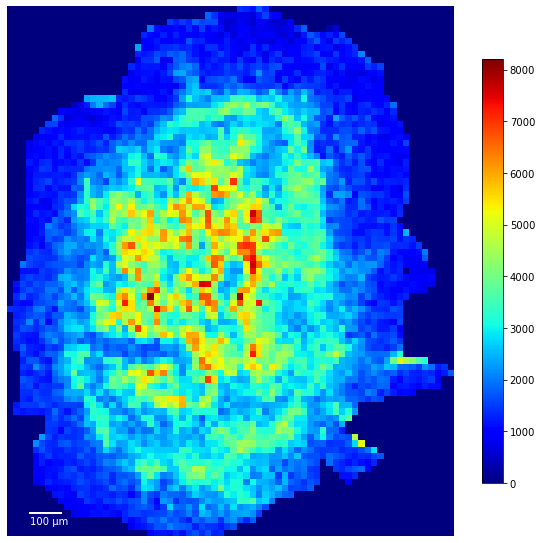

346.055724-AMP done


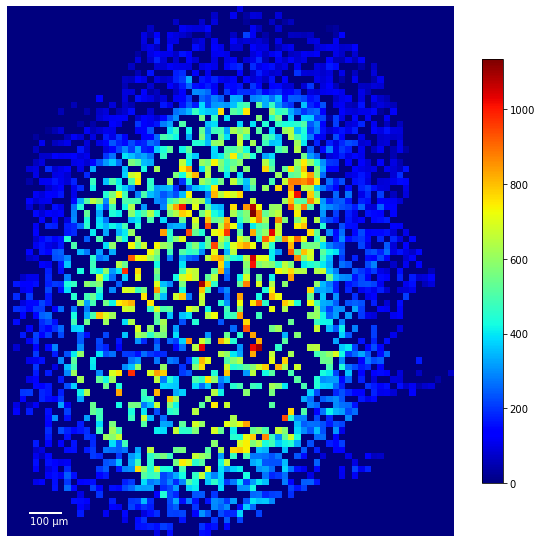

347.03972400000004-IMP done


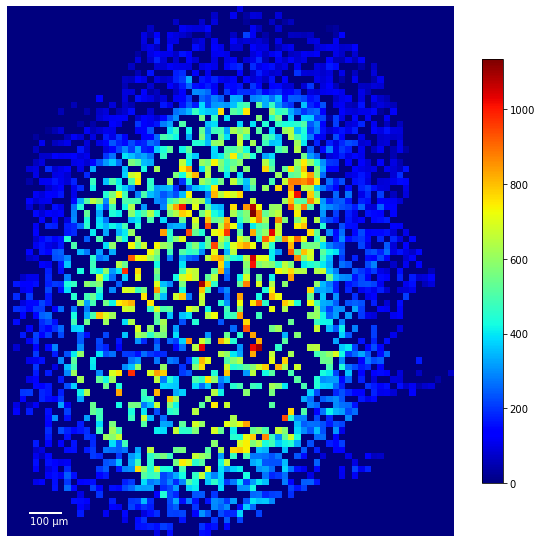

347.0398239-IMP done


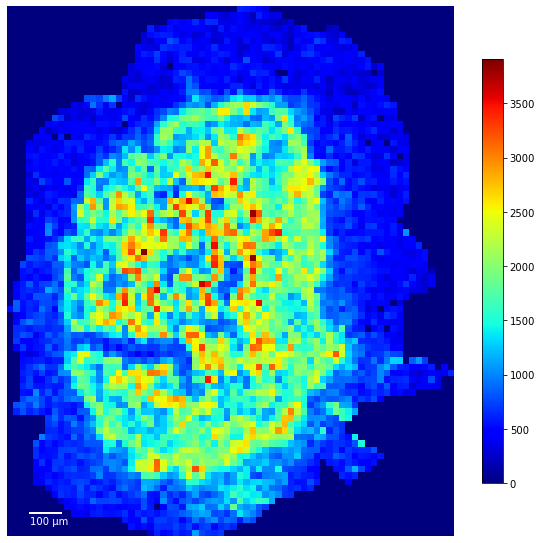

362.050723-GMP done


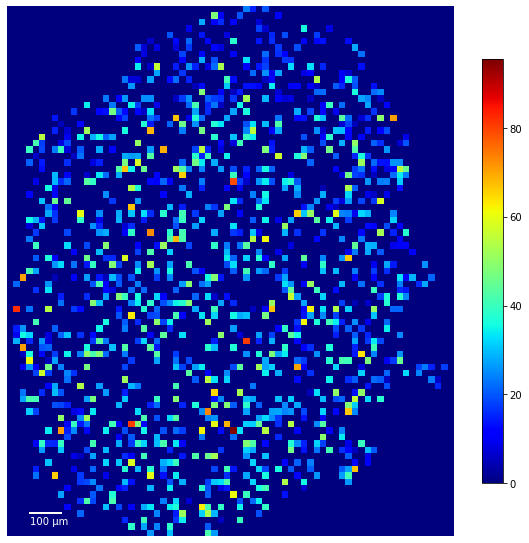

367.01841980000006-Orotidine 5'-monophosphate done


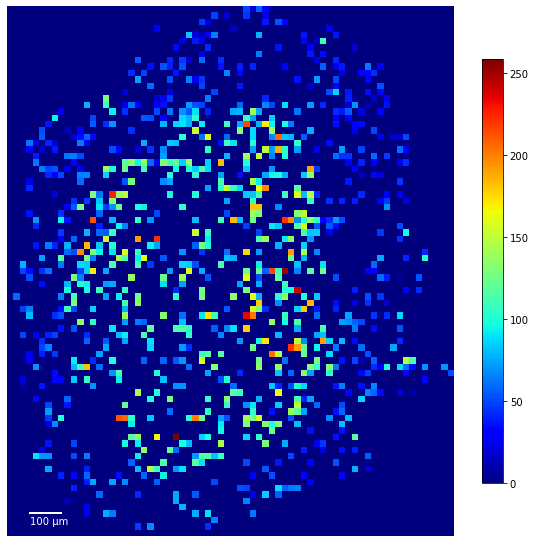

368.9993376-Sedoheptulose 1,7-bisphosphate done


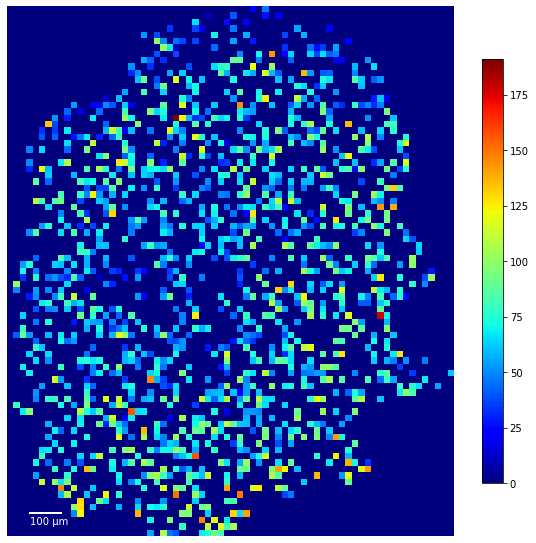

374.1328589-HP done


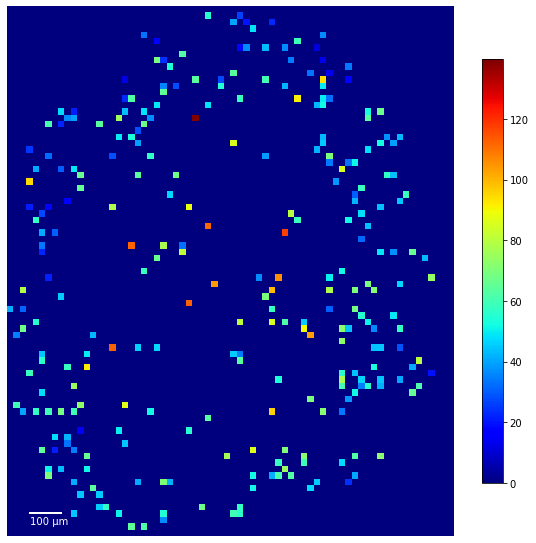

386.0159907-dCDP done


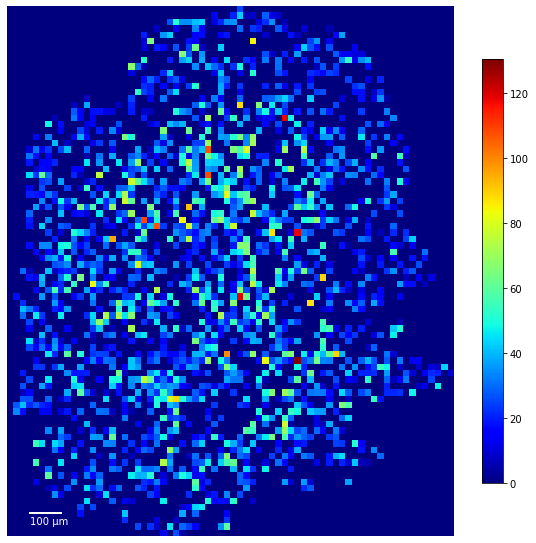

388.9445387-phosphoribosylpyrophosphate done


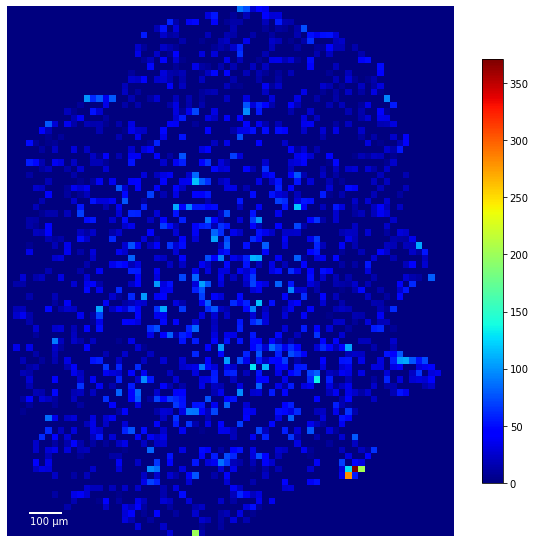

401.01565639999995-dTDP done


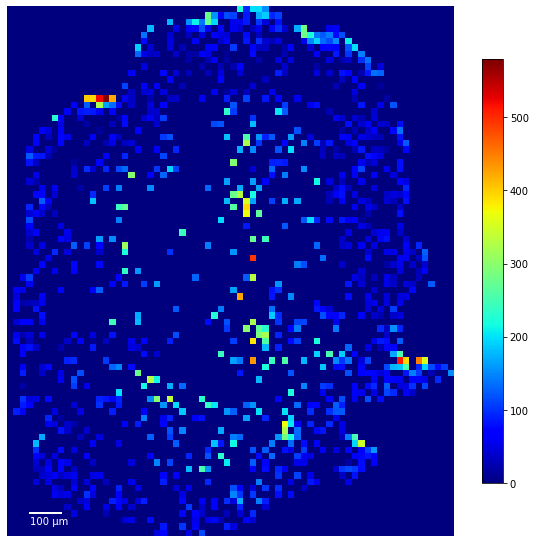

402.01090539999996-CDP done


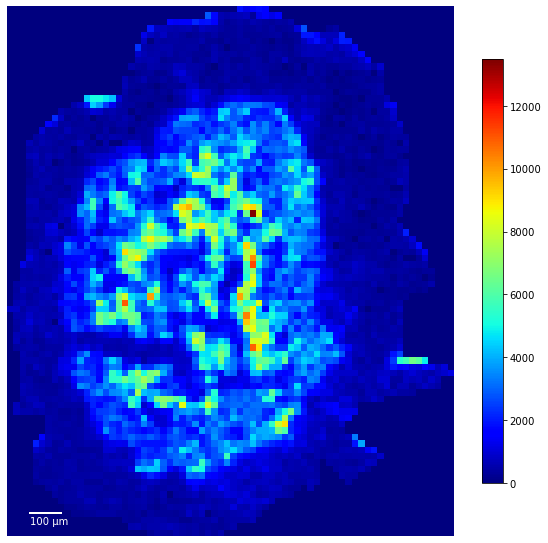

402.99492089999995-UDP  done


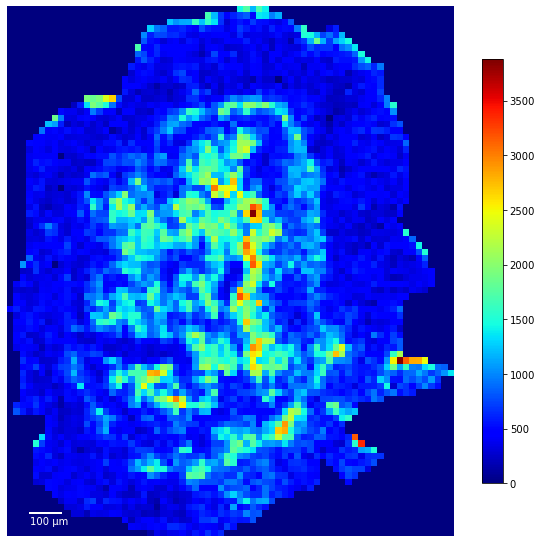

426.021724-ADP done


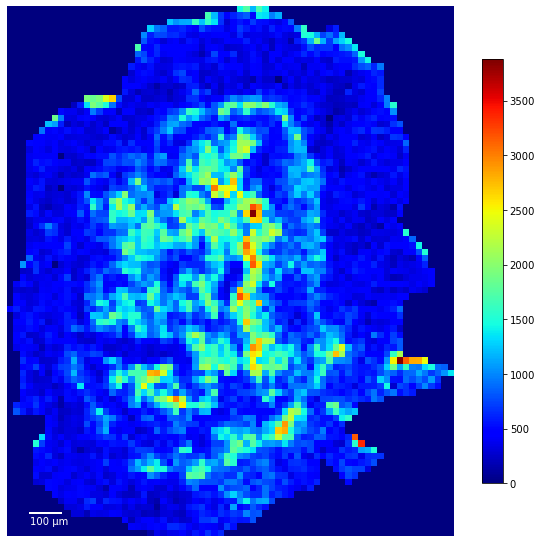

426.0221387-dGDP done


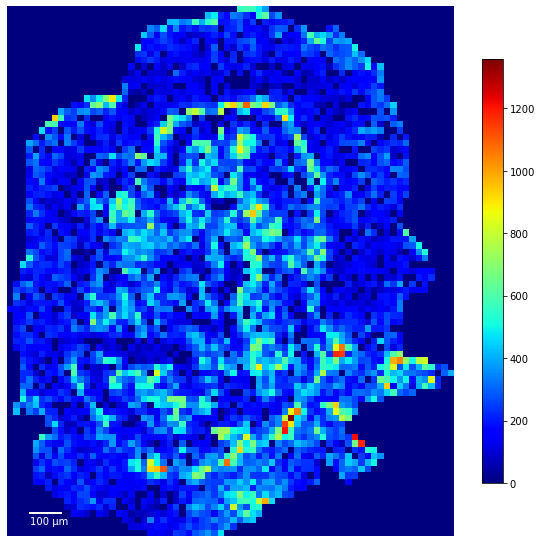

442.0170534-GDP done


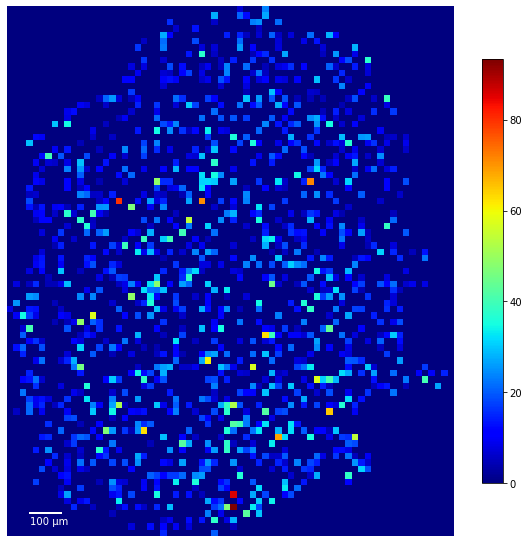

446.9847502-Orotidine-bismonophosphate done


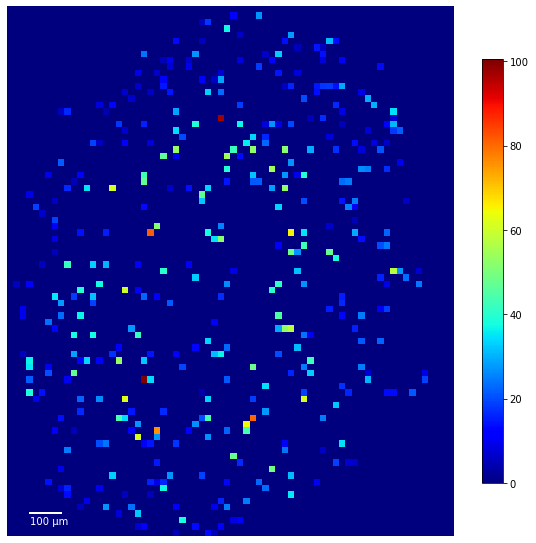

465.98232110000004-dCTP done


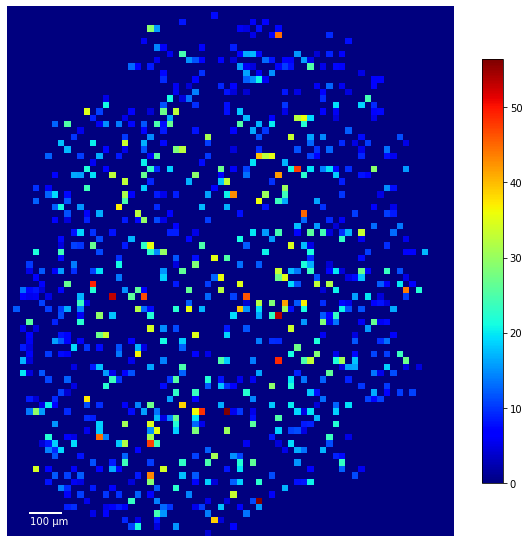

466.96633669999994-dUTP done


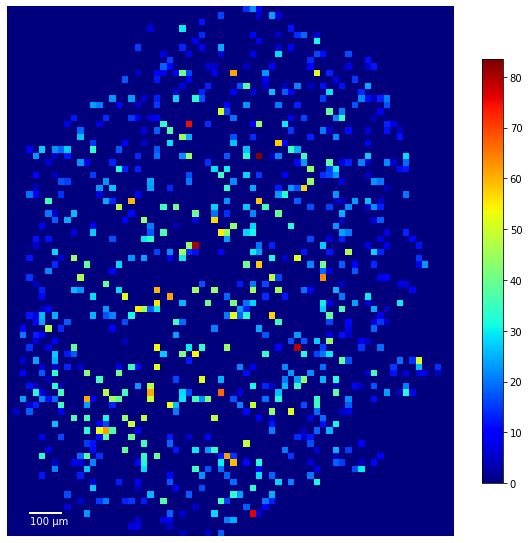

480.98198679999996-dTTP done


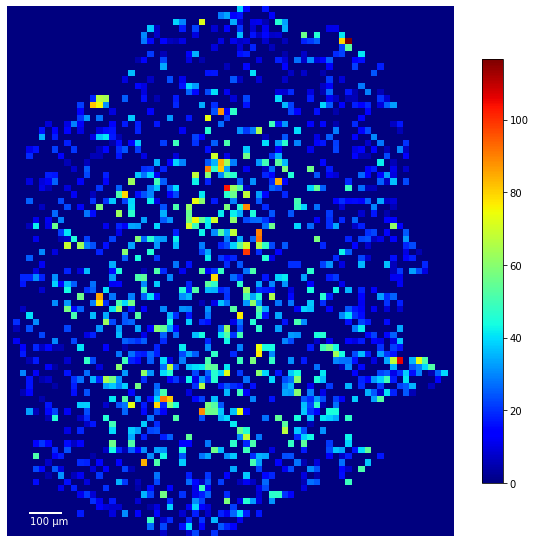

481.9772358-CTP done


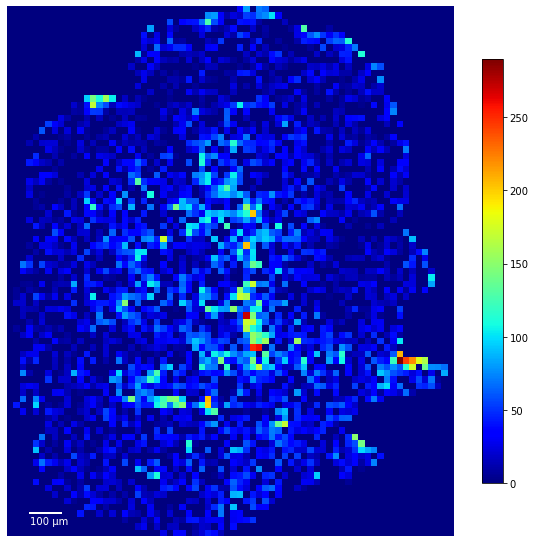

482.9612513999999-UTP done


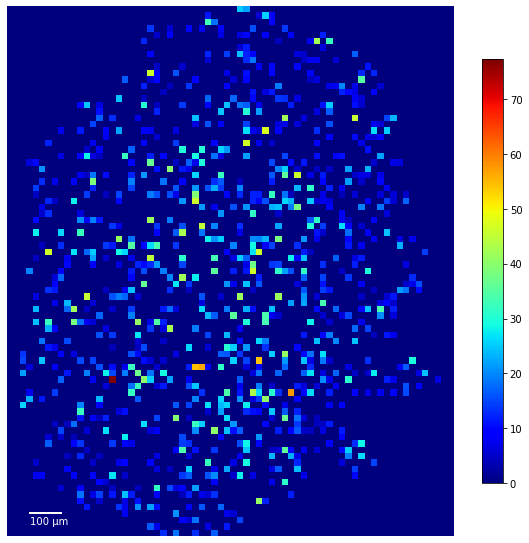

489.9935545-dATP done


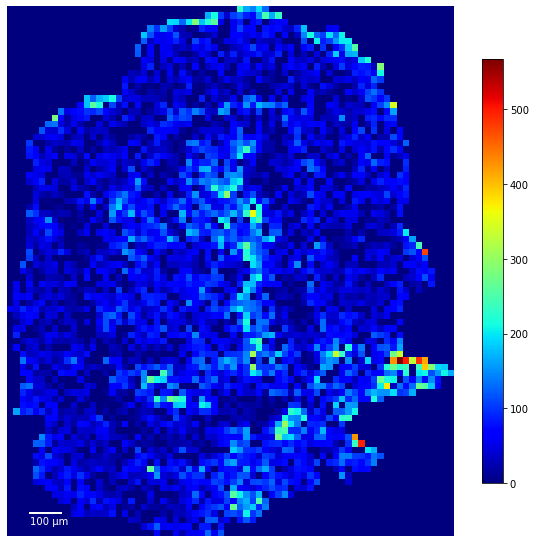

505.9884692-dGTP done


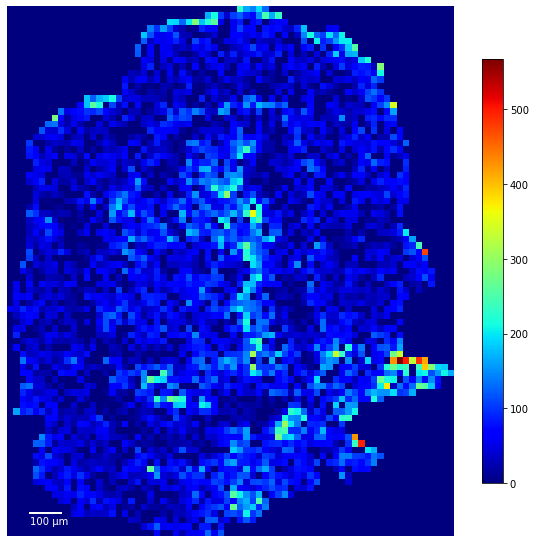

505.9884692-dGTP done


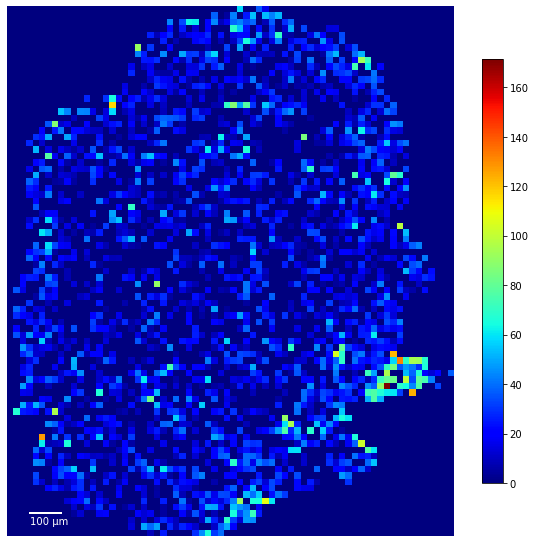

521.9833838000001-GTP done


In [7]:
# parent_dir = 'E:\\MALDI Raw Data\\NA\\A2\\Cer\\230622Spheroids-5-A2-Laser30_left_NA_rawDATA inner'
# file_intensity = os.path.join(parent_dir,'inner region-Total Ion Count_col.csv')
# file_coordinates = os.path.join(parent_dir,'230622Spheroids-5-A2_left_NA_rawDATA_regionSpots.csv')
# feature_list_path = os.path.join(parent_dir,'05-PeakList-PyMTSphingolipidProfile-Neg-3.csv')
# skip_rows_intensity = 10
# skip_rows_coordinates = 8
# main(parent_dir,file_intensity,file_coordinates,feature_list_path,skip_rows_intensity,skip_rows_coordinates)

# parent_dir = 'E:\\MALDI Raw Data\\NA\\A2\\Cer\\230622Spheroids-5-A2-Laser30_left_NA_rawDATA_outer'
# file_intensity = os.path.join(parent_dir,'outer region-Total Ion Count_col.csv')
# file_coordinates = os.path.join(parent_dir,'230622Spheroids-5-A2_left_NA_rawDATA_regionSpots.csv')
# feature_list_path = os.path.join(parent_dir,'05-PeakList-PyMTSphingolipidProfile-Neg-3.csv')
# skip_rows_intensity = 10
# skip_rows_coordinates = 8
# main(parent_dir,file_intensity,file_coordinates,feature_list_path,skip_rows_intensity,skip_rows_coordinates)

# parent_dir = 'E:\\MALDI Raw Data\\NA\\A2\\Met\\230703Spheroids-6-A2-Laser70_left_NA_rawDATA_inner'
# file_intensity = os.path.join(parent_dir,'inner region-Total Ion Count_col.csv')
# file_coordinates = os.path.join(parent_dir,'230703Spheroids-6-A2-Laser70_left_NA_rawDATA_regionSpots.csv')
# feature_list_path = os.path.join(parent_dir,'K17Metabolites-Raafat-FeatureList - adjusted glucose.csv')
# skip_rows_intensity = 10
# skip_rows_coordinates = 8
# main(parent_dir,file_intensity,file_coordinates,feature_list_path,skip_rows_intensity,skip_rows_coordinates)

# parent_dir = 'E:\\MALDI Raw Data\\NA\\A2\\Met\\230703Spheroids-6-A2-Laser70_left_NA_rawDATA_outer'
# file_intensity = os.path.join(parent_dir,'outer region-Total Ion Count_col.csv')
# file_coordinates = os.path.join(parent_dir,'230703Spheroids-6-A2-Laser70_left_NA_rawDATA_regionSpots.csv')
# feature_list_path = os.path.join(parent_dir,'K17Metabolites-Raafat-FeatureList - adjusted glucose.csv')
# skip_rows_intensity = 10
# skip_rows_coordinates = 8
# main(parent_dir,file_intensity,file_coordinates,feature_list_path,skip_rows_intensity,skip_rows_coordinates)

# parent_dir = 'E:\\MALDI Raw Data\\AA\\B1\\Met\\230703Spheroids-6-B1-Laser50_right_AA_rawDATA_inner'
# file_intensity = os.path.join(parent_dir,'inner region-Total Ion Count_col.csv')
# file_coordinates = os.path.join(parent_dir,'230703Spheroids-6-B1-Laser50_right_AA_rawDATA_regionSpots.csv')
# feature_list_path = os.path.join(parent_dir,'K17Metabolites-Raafat-FeatureList.csv')
# skip_rows_intensity = 10
# skip_rows_coordinates = 8
# main(parent_dir,file_intensity,file_coordinates,feature_list_path,skip_rows_intensity,skip_rows_coordinates)

# parent_dir = 'E:\\MALDI Raw Data\\AA\\B1\\Met\\230703Spheroids-6-B1-Laser50_right_AA_rawDATA_outer'
# file_intensity = os.path.join(parent_dir,'outer region-Total Ion Count_col.csv')
# file_coordinates = os.path.join(parent_dir,'230703Spheroids-6-B1-Laser50_right_AA_rawDATA_regionSpots.csv')
# feature_list_path = os.path.join(parent_dir,'K17Metabolites-Raafat-FeatureList.csv')
# skip_rows_intensity = 10
# skip_rows_coordinates = 8
# main(parent_dir,file_intensity,file_coordinates,feature_list_path,skip_rows_intensity,skip_rows_coordinates)

# parent_dir = 'E:\\MALDI Raw Data\\NA\\A2\\SM\\230616Spheroids-4-A2_left_NA_rawDATA_inner'
# file_intensity = os.path.join(parent_dir,'inner region-Total Ion Count_col.csv')
# file_coordinates = os.path.join(parent_dir,'230616Spheroids-4-A2_left_NA_rawDATA_regionSpots.csv')
# feature_list_path = os.path.join(parent_dir,'04-PeakList-PyMTSphingolipidProfile-Pos-2.csv')
# skip_rows_intensity = 10
# skip_rows_coordinates = 8
# main(parent_dir,file_intensity,file_coordinates,feature_list_path,skip_rows_intensity,skip_rows_coordinates)

# parent_dir = 'E:\\MALDI Raw Data\\AA\\B1\\Cer\\230622Spheroids-5-B1-Laser30_right_AA_rawDATA_inner'
# file_intensity = os.path.join(parent_dir,'inner region-Total Ion Count_col.csv')
# file_coordinates = os.path.join(parent_dir,'230622Spheroids-5-B1-Laser30_right_AA_rawDATA_regionSpots.csv')
# feature_list_path = os.path.join(parent_dir,'05-PeakList-PyMTSphingolipidProfile-Neg-3.csv')
# skip_rows_intensity = 10
# skip_rows_coordinates = 8
# main(parent_dir,file_intensity,file_coordinates,feature_list_path,skip_rows_intensity,skip_rows_coordinates)

# parent_dir = 'E:\\MALDI Raw Data\\AA\\B1\\SM\\230616Spheroids-4-B1_right_AA_rawDATA_inner'
# file_intensity = os.path.join(parent_dir,'inner region-Total Ion Count_col.csv')
# file_coordinates = os.path.join(parent_dir,'230616Spheroids-4-B1_right_AA_rawDATA_regionSpots.csv')
# feature_list_path = os.path.join(parent_dir,'04-PeakList-PyMTSphingolipidProfile-Pos-2.csv')
# skip_rows_intensity = 10
# skip_rows_coordinates = 8
# main(parent_dir,file_intensity,file_coordinates,feature_list_path,skip_rows_intensity,skip_rows_coordinates)

# parent_dir = 'E:\\MALDI Raw Data\\NA\\A1\\Met\\230703Spheroids-6-A1-Laser50_left_NA_rawDATA_inner'
# file_intensity = os.path.join(parent_dir,'inner region-Total Ion Count_col.csv')
# file_coordinates = os.path.join(parent_dir,'230703Spheroids-6-A1-Laser50_left_NA_rawDATA_regionSpots.csv')
# feature_list_path = os.path.join(parent_dir,'K17Metabolites-Raafat-FeatureList.csv')
# skip_rows_intensity = 10
# skip_rows_coordinates = 8
# main(parent_dir,file_intensity,file_coordinates,feature_list_path,skip_rows_intensity,skip_rows_coordinates)

# parent_dir = 'E:\\MALDI Raw Data\\NA\\A3\\Cer\\230622Spheroids-5-A3-Laser25_left_NA_rawDATA_inner'
# file_intensity = os.path.join(parent_dir,'inner region-Total Ion Count_col.csv')
# file_coordinates = os.path.join(parent_dir,'230622Spheroids-5-A3-Laser25_left_NA_rawDATA_regionSpots.csv')
# feature_list_path = os.path.join(parent_dir,'05-PeakList-PyMTSphingolipidProfile-Neg-3.csv')
# skip_rows_intensity = 10
# skip_rows_coordinates = 8
# main(parent_dir,file_intensity,file_coordinates,feature_list_path,skip_rows_intensity,skip_rows_coordinates)

# parent_dir = 'E:\\MALDI Raw Data\\NA\\A3\\Met\\230703Spheroids-6-A3-Laser60_left_NA_rawDATA_inner'
# file_intensity = os.path.join(parent_dir,'inner region-Total Ion Count_col.csv')
# file_coordinates = os.path.join(parent_dir,'230703Spheroids-6-A3-Laser60_left_NA_rawDATA_regionSpots.csv')
# feature_list_path = os.path.join(parent_dir,'K17Metabolites-Raafat-FeatureList.csv')
# skip_rows_intensity = 10
# skip_rows_coordinates = 8
# main(parent_dir,file_intensity,file_coordinates,feature_list_path,skip_rows_intensity,skip_rows_coordinates)

# parent_dir = 'E:\\MALDI Raw Data\\NA\\A3\\SM\\230617Spheroids-4-A3_left_NA_rawDATA_inner'
# file_intensity = os.path.join(parent_dir,'inner region-Total Ion Count_col.csv')
# file_coordinates = os.path.join(parent_dir,'230617Spheroids-4-A3_left_NA_rawDATA_regionSpots.csv')
# feature_list_path = os.path.join(parent_dir,'04-PeakList-PyMTSphingolipidProfile-Pos-2.csv')
# skip_rows_intensity = 10
# skip_rows_coordinates = 8
# main(parent_dir,file_intensity,file_coordinates,feature_list_path,skip_rows_intensity,skip_rows_coordinates)

# parent_dir = 'E:\\MALDI Raw Data\\AA\\B2\\Cer\\230622Spheroids-5-B2-Laser25_right_AA_rawDATA_inner'
# file_intensity = os.path.join(parent_dir,'inner region-Total Ion Count_col.csv')
# file_coordinates = os.path.join(parent_dir,'230622Spheroids-5-B2-Laser25_right_AA_rawDATA_regionSpots.csv')
# feature_list_path = os.path.join(parent_dir,'05-PeakList-PyMTSphingolipidProfile-Neg-3.csv')
# skip_rows_intensity = 10
# skip_rows_coordinates = 8
# main(parent_dir,file_intensity,file_coordinates,feature_list_path,skip_rows_intensity,skip_rows_coordinates)

# parent_dir = 'E:\\MALDI Raw Data\\AA\\B2\\Met\\230703Spheroids-6-B2-Laser70_right_AA_rawDATA_inner'
# file_intensity = os.path.join(parent_dir,'inner region-Total Ion Count_col.csv')
# file_coordinates = os.path.join(parent_dir,'230703Spheroids-6-B2-Laser70_right_AA_rawDATA_regionSpots.csv')
# feature_list_path = os.path.join(parent_dir,'K17Metabolites-Raafat-FeatureList.csv')
# skip_rows_intensity = 10
# skip_rows_coordinates = 8
# main(parent_dir,file_intensity,file_coordinates,feature_list_path,skip_rows_intensity,skip_rows_coordinates)

# parent_dir = 'E:\\MALDI Raw Data\\AA\\B2\\SM\\230617Spheroids-4-B2_right_AA_rawDATA inner'
# file_intensity = os.path.join(parent_dir,'inner region-Total Ion Count_col.csv')
# file_coordinates = os.path.join(parent_dir,'230617Spheroids-4-B2_right_AA_rawDATA_regionSpots.csv')
# feature_list_path = os.path.join(parent_dir,'04-PeakList-PyMTSphingolipidProfile-Pos-2.csv')
# skip_rows_intensity = 10
# skip_rows_coordinates = 8
# main(parent_dir,file_intensity,file_coordinates,feature_list_path,skip_rows_intensity,skip_rows_coordinates)

parent_dir='/mnt/data10/shared/yujie/raffat_data/Raw Data/NA/A3/Met/230703Spheroids-6-A3-Laser60_left_NA_rawDATA_outer'
file_intensity = os.path.join(parent_dir,'outer region-Total Ion Count_col.csv')
file_coordinates = os.path.join(parent_dir,'230703Spheroids-6-A3-Laser60_left_NA_rawDATA_regionSpots.csv')
feature_list_path = os.path.join(parent_dir,'K17Metabolites-Raafat-FeatureList.csv')
skip_rows_intensity = 10
skip_rows_coordinates = 8
main(parent_dir,file_intensity,file_coordinates,feature_list_path,skip_rows_intensity,skip_rows_coordinates)


In [37]:
#########uni_test
import pandas as pd
import matplotlib.image as mpimg
import os
import matplotlib.lines as mlines
parent_dir='/mnt/data10/shared/yujie/raffat_data/Raw Data/NA/A3/Met/230703Spheroids-6-A3-Laser60_left_NA_rawDATA_outer'
file_intensity = os.path.join(parent_dir,'outer region-Total Ion Count_col.csv')
file_coordinates = os.path.join(parent_dir,'230703Spheroids-6-A3-Laser60_left_NA_rawDATA_regionSpots.csv')
feature_list_path = os.path.join(parent_dir,'K17Metabolites-Raafat-FeatureList.csv')
skip_rows_intensity = 10
skip_rows_coordinates = 8


scale_bar_micrometers = 100
scale_bar_pixels = scale_bar_micrometers / 20  # Convert to pixels (each pixel is 20 micrometers)


df_feature_list = pd.read_csv(feature_list_path, delimiter=';', skiprows=8)
#image_software_dir = '/mnt/data10/shared/yujie/raffat_data/MCF7/Spheroid6_A2_B2_Laser70_Metabolites_rawDATA/scilab_fig'

df_intensity = pd.read_csv(file_intensity, skiprows=skip_rows_intensity, header=0, delimiter=';')


df_coordinates = pd.read_csv(file_coordinates, skiprows=skip_rows_coordinates, delimiter=';')

# Renaming columns in df_coordinates for clarity
df_coordinates.columns = ['Spot', 'x', 'y']
#!!!!!mismatch between the 2 df(regions start from spot 0, intensities start from spot 1)
df_coordinates['Spot'] = df_coordinates['Spot']+1

#select only the spots used in df_intensities
spot_numbers = [int(col.split(' ')[1]) for col in df_intensity.columns if 'Spot' in col]
selected_coordinates = df_coordinates[df_coordinates['Spot'].isin(spot_numbers)]
#print(selected_coordinates.head(5))

#convert from micro to pixel
df_converted_coordinates = convert_coordinates(selected_coordinates)
# Directory for saving images
#output_dir = '/path/to/output/directory'
#os.makedirs(output_dir, exist_ok=True)

num_mz_values = len(df_intensity['m/z'])
print(f'parent dir {parent_dir} \n feature list {feature_list_path} \n total number of m/z values: {num_mz_values}')

idx = 26
mz_value = 259.02244249999995


parent dir /mnt/data10/shared/yujie/raffat_data/Raw Data/NA/A3/Met/230703Spheroids-6-A3-Laser60_left_NA_rawDATA_outer 
 feature list /mnt/data10/shared/yujie/raffat_data/Raw Data/NA/A3/Met/230703Spheroids-6-A3-Laser60_left_NA_rawDATA_outer/K17Metabolites-Raafat-FeatureList.csv 
 total number of m/z values: 64


(83, 70)


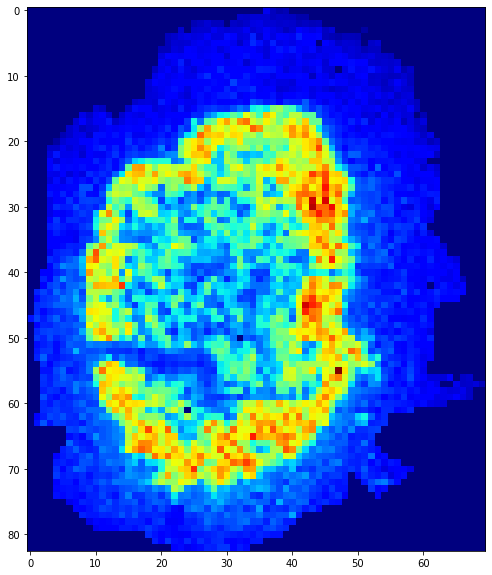

In [43]:
image = create_intensity_image(df_intensity, df_converted_coordinates, mz_value, 1)
print(image.shape)
fig, ax1 = plt.subplots(figsize=(10, 10))
cax = ax1.imshow(np.flipud(image), cmap='jet')
plt.show()

(83, 70)


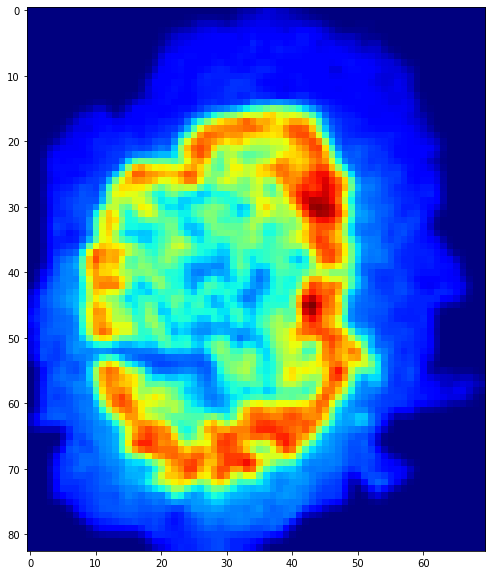

In [42]:
image = create_intensity_image(df_intensity, df_converted_coordinates, mz_value, 1,smooth=True,kernel_size=3)
print(image.shape)
fig, ax1 = plt.subplots(figsize=(10, 10))
cax = ax1.imshow(np.flipud(image), cmap='jet')
plt.show()

(83, 70)


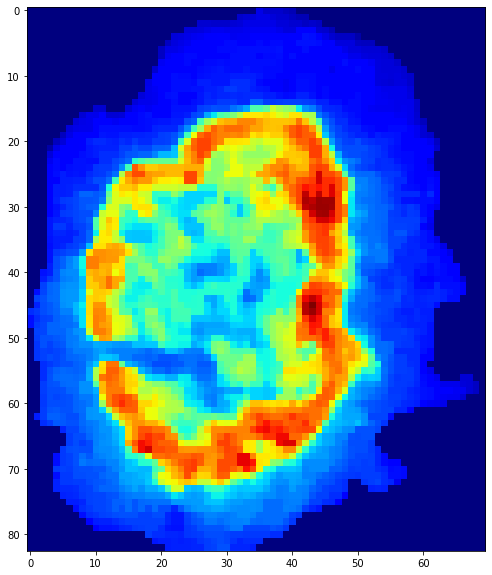

In [47]:
image = create_intensity_image(df_intensity, df_converted_coordinates, mz_value, 1,smooth=True,smooth_method='median',kernel_size=3)
print(image.shape)
fig, ax1 = plt.subplots(figsize=(10, 10))
cax = ax1.imshow(np.flipud(image), cmap='jet')
plt.show()

(83, 70)


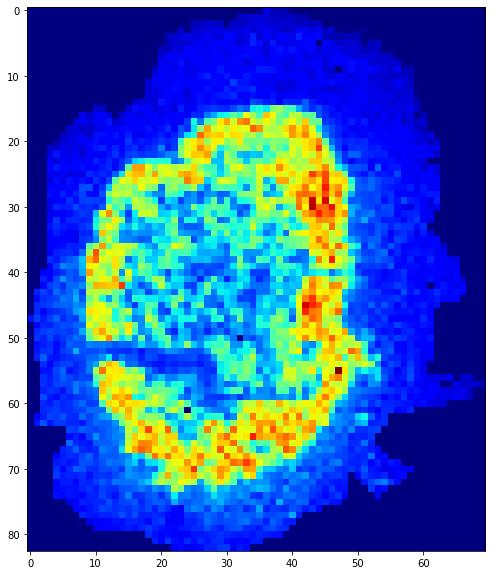

In [48]:
image = create_intensity_image(df_intensity, df_converted_coordinates, mz_value, 1,denoise=True)
print(image.shape)
fig, ax1 = plt.subplots(figsize=(10, 10))
cax = ax1.imshow(np.flipud(image), cmap='jet')
plt.show()